In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import xclib.data.data_utils as du
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from IPython.display import display
from timeit import default_timer as timer
import xclib.evaluation.xc_metrics as xc_metrics

In [2]:
import matplotlib.pyplot as plt

In [3]:
plt.style.use('dark_background')

# Code

In [4]:
def read_id(filename, rm_suffix_idx=None):
    text = []
    with open(filename) as file:
        for line in file:
            text.append(line[:-1].split('->', maxsplit=1)[0][:rm_suffix_idx])
    return text

def read_ids(data_dir, rm_suffix_idx=None, meta_tag=""):
    trn_id = read_id(f"{data_dir}/raw_data/train.raw.txt", rm_suffix_idx)
    tst_id = read_id(f"{data_dir}/raw_data/test.raw.txt", rm_suffix_idx)
    lbl_id = read_id(f"{data_dir}/raw_data/label.raw.txt", rm_suffix_idx)
    if meta_tag:
        meta_id = read_map(f"{data_dir}/raw_data/{meta_tag}.raw.txt", rm_suffix_idx)
        return trn_id, tst_id, lbl_id, meta_id
    return trn_id, tst_id, lbl_id


In [5]:
def read_map(filename):
    text = []
    with open(filename) as file:
        for line in file:
            text.append(line[:-1].split('->', maxsplit=1)[1])
    return text


In [6]:
def read_XC_data(data_dir, meta_tag=""):
    data_tag = f"{meta_tag}_" if meta_tag else meta_tag
    trn_xy = du.read_sparse_file(f"{data_dir}/{data_tag}trn_X_Y.txt")
    tst_xy = du.read_sparse_file(f"{data_dir}/{data_tag}tst_X_Y.txt")
    
    trn_map = read_map(f"{data_dir}/raw_data/train.raw.txt")
    tst_map = read_map(f"{data_dir}/raw_data/test.raw.txt")
    lbl_map = read_map(f"{data_dir}/raw_data/label.raw.txt")
        
    if meta_tag:
        lbl_xy = du.read_sparse_file(f"{data_dir}/{data_tag}lbl_X_Y.txt")
        meta_map = read_map(f"{data_dir}/raw_data/{meta_tag}.raw.txt")
        return (trn_xy, tst_xy, lbl_xy), (trn_map, tst_map, lbl_map, meta_map)
    return (trn_xy, tst_xy), (trn_map, tst_map, lbl_map)


In [7]:
def read_augmented_maps(data_dir, meta_tag=""):
    trn_map = read_map(f"{data_dir}/raw_data/train_{meta_tag}.raw.txt")
    tst_map = read_map(f"{data_dir}/raw_data/test_{meta_tag}.raw.txt")
    lbl_map = read_map(f"{data_dir}/raw_data/label_{meta_tag}.raw.txt")
    return trn_map, tst_map, lbl_map


In [8]:
def read_filter_files(data_dir):
    filter_trn = np.loadtxt(f"{data_dir}/filter_labels_train.txt", dtype=np.int64)
    filter_tst = np.loadtxt(f"{data_dir}/filter_labels_test.txt", dtype=np.int64)
    
    return filter_trn, filter_tst


In [9]:
def load_XC_predictions(pred_file):
    output = np.load(pred_file)
    return csr_matrix((output['data'], output['indices'], output['indptr']), 
                      dtype=float, shape=output['shape'])


In [10]:
def read_XC_results(result_dir):
    pred_trn = load_XC_predictions(f"{result_dir}/trn_predictions_clf.npz")
    pred_tst = load_XC_predictions(f"{result_dir}/tst_predictions_clf.npz")
    return pred_trn, pred_tst


# Load

## Code

In [11]:
def keep_topk_predictions(pred, topk):
    num_preds = pred[0].getnnz()
    
    data, indices, indptr = [], [], []
    data = pred.data.reshape(-1, num_preds)[:, :topk].reshape(-1)
    indices = pred.indices.reshape(-1, num_preds)[:, :topk].reshape(-1)
    indptr = np.arange(0, topk*(pred.shape[0]+1), topk)
    
    return csr_matrix((data, indices, indptr), dtype=pred.dtype)


In [12]:
def _pointwise_topk_eval(preds, tst_xy, topk, metric="P", return_mat=False):
    top_preds = keep_topk_predictions(preds, topk)
    return _pointwise_eval(top_preds, tst_xy, metric=metric, return_mat=return_mat)

def _pointwise_eval(preds, tst_xy, metric="P", return_mat=False):
    _preds = preds.multiply(tst_xy)
    _preds.eliminate_zeros()
    
    if metric == "P":
        deno = preds[0].getnnz()
    elif metric == "R":
        deno = tst_xy.sum(axis=1)
    
    if return_mat:
        _preds.data[:] = 1
        return _preds/(deno*_preds.shape[0])
        
    return np.ravel(_preds.getnnz(axis=1)/deno)


In [13]:
def get_eval_diff(pred_1, pred_2, tst_xy, metric="P", return_eval=False):
    eval_pred_1 = _pointwise_eval(pred_1, tst_xy, metric)
    eval_pred_2 = _pointwise_eval(pred_2, tst_xy, metric)
    
    eval_diff = eval_pred_1 - eval_pred_2
    sorted_eval_idxs = np.argsort(eval_diff)
    
    if return_eval:
        return eval_diff, eval_pred_1, eval_pred_2
    return eval_diff

def get_topk_eval_diff(pred_1, pred_2, tst_xy, topk=5, metric="P", return_eval=False):
    topk_pred_1 = keep_topk_predictions(pred_1, topk=topk)
    topk_pred_2 = keep_topk_predictions(pred_2, topk=topk)
    
    return get_eval_diff(topk_pred_1, topk_pred_2, tst_xy, metric=metric, 
                         return_eval=return_eval)


In [14]:
def get_examples(idx, gain, xy_data, xy_pred, aug_pred, xy_map, aug_map):
    print(f"Gain        : {gain[idx]}\n")
    
    print(f"Datapoint   : {xy_map[0][idx]}")
    print(f"Prediction  : ")
    for label in np.array(xy_map[1])[xy_pred[idx].indices]:
        print(f"->{label}")
    print()
    
    print(f"Datapoint   : {aug_map[0][idx]}")
    print(f"Prediction  : ")
    for label in np.array(xy_map[1])[aug_pred[idx].indices]:
        print(f"->{label}")
    print()
    
    print(f"Labels      :")
    for label in np.array(xy_map[1])[xy_data[idx].indices]:
        print(f"->{label}")
    print()
         

In [15]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)
    

In [16]:
def apply_filter_file(preds, filter_idx):
    preds[filter_idx[:, 0], filter_idx[:, 1]] = 0
    preds.eliminate_zeros()
    

## G-LF-WikiSeeAlsoTitles-300K

In [17]:
set_default()

In [18]:
data_dir = "/home/scai/phd/aiz218323/tmp/XC/data/G-LF-WikiSeeAlsoTitles-300K/"

xy_data, xy_maps = read_XC_data(data_dir)
filter_idx = read_filter_files(data_dir)

aug_maps = read_augmented_maps(data_dir, meta_tag="category")

In [19]:
result_dir = "/home/scai/phd/aiz218323/tmp/XC/results/NGAME/STransformer/\
G-LF-WikiSeeAlsoTitles-300K/v_0_100/"
_, v_0_100_preds = read_XC_results(result_dir)

result_dir = "/home/scai/phd/aiz218323/tmp/XC/results/NGAME/STransformer/\
G-LF-WikiSeeAlsoTitles-300K/v_1_100/"
_, v_1_100_preds = read_XC_results(result_dir)

### Label distribution

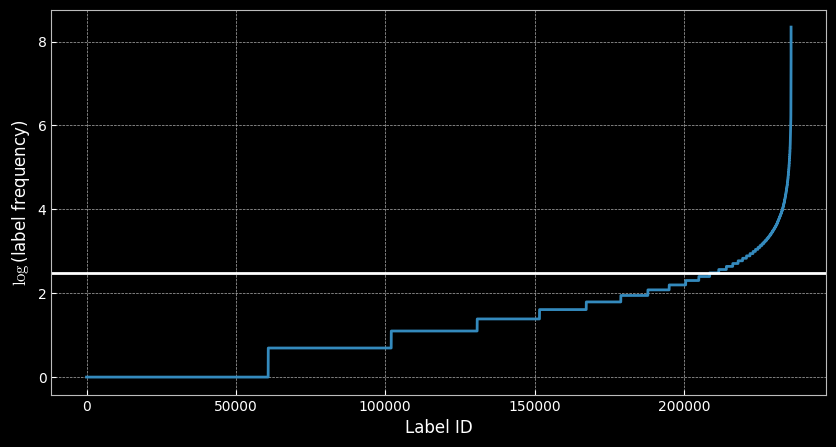

In [52]:
lbl_freq = xy_data[0].getnnz(axis=0)
log_lbl_freq = np.log(lbl_freq)
sort_lbl_freq_idx = np.argsort(lbl_freq)

plt.figure(figsize=(10, 5))
plt.plot(log_lbl_freq[sort_lbl_freq_idx])
plt.axhline(y = log_lbl_freq[int(lbl_freq.shape[0]*0.8)], linestyle = '-')
plt.xlabel("Label ID")
plt.ylabel(r"$\log$(label frequency)")
plt.show()

### Examples

In [20]:
_topk = 5
topk_pred_v_1_100 = keep_topk_predictions(v_1_100_preds, topk=_topk)
topk_pred_v_0_100 = keep_topk_predictions(v_0_100_preds, topk=_topk)

eval_diff = get_eval_diff(topk_pred_v_1_100, topk_pred_v_0_100, xy_data[1], metric="P")

In [56]:
get_examples(eval_sort_idxs[-1], eval_diff, xy_data[1], topk_pred_v_0_100, 
             topk_pred_v_1_100, xy_maps[1:], aug_maps[1:])

Gain        : 1.0

Datapoint   : cottonwood Limestone
Prediction  : 
->paleontology in Idaho
->paleontology in Arizona
->paleontology in Missouri
->list of fossiliferous stratigraphic units in Idaho
->danata Formation

Datapoint   : cottonwood Limestone,building stone,permian Kansas,cisuralian Series of North America,geologic formations of Nebraska,geologic formations of Oklahoma
Prediction  : 
->list of fossiliferous stratigraphic units in Nebraska
->paleontology in Nebraska
->list of fossiliferous stratigraphic units in Kansas
->paleontology in Kansas
->list of fossiliferous stratigraphic units in Oklahoma

Labels      :
->paleontology in Nebraska
->paleontology in Kansas
->paleontology in Oklahoma
->list of fossiliferous stratigraphic units in Nebraska
->list of fossiliferous stratigraphic units in Kansas
->list of fossiliferous stratigraphic units in Oklahoma



### Gains

In [375]:
np.sum(eval_diff > 0), np.sum(eval_diff < 0)

(84821, 16456)

In [380]:
np.array(xy_maps[1])[np.where(eval_diff > 0)[0]]

array(['pavel Shurukhin', 'from Q with Love', 'rabie Chaki', ...,
       'maryland, My Maryland', 'nutter Fork',
       'black Catholic Theological Symposium'], dtype='<U134')

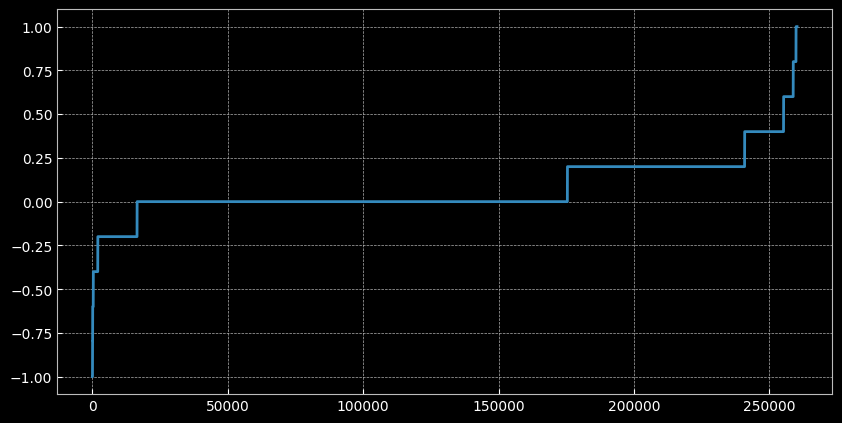

In [373]:
plt.figure(figsize=(10, 5))
plt.plot(eval_diff[eval_sort_idxs])

### Label-wise gains

In [306]:
def _freq_label_partition(xy_data, num_groups=10):
    lbl_freq = xy_data.getnnz(axis=0)
    sorted_lbl_freq_idx = np.argsort(lbl_freq)
    
    num_lbl_per_group = len(lbl_freq)//num_groups
    
    idxs = []
    for i in range(0, num_groups):
        k = i*num_lbl_per_group
        idxs.append(sorted_lbl_freq_idx[k:k+num_lbl_per_group].tolist())
        
    return idxs


In [309]:
def _label_eval(preds, xy_data, topk, num_groups=10, metric="P"):
    eval_mat = _pointwise_topk_eval(preds, xy_data, topk, metric=metric, 
                                    return_mat=True)
    lbl_partition_idx = _freq_label_partition(xy_data, num_groups=num_groups)
    
    lbl_partition_eval = list()
    for idx in lbl_partition_idx:
        lbl_partition_eval.append(eval_mat[:, idx].sum())
        
    return lbl_partition_eval


In [339]:
def _plot_multiple_bar_plot(comparison_list, labels, xlabel, ylabel, bar_width=0.25):
    fig = plt.figure(figsize=(12, 8))
    
    for i, y_val in enumerate(comparison_list):
        x_val = [x + i*bar_width for x in range(len(y_val))]
        plt.bar(x_val, y_val, width=bar_width, edgecolor="grey", label=labels[i])
        
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    
    _decile_val = np.linspace(0, 100, len(y_val)+1)
    x_labels = [f"${_decile_val[i]:.0f}-{_decile_val[i+1]:.0f}\%$" for i in range(len(_decile_val)-1)]
    
    plt.xticks([x + (i/2)*bar_width for x in range(len(y_val))], x_labels)
    plt.legend()
        
    plt.show()


In [353]:
v_1_100_lbl_eval = _label_eval(v_1_100_preds, xy_data[1], topk=5, 
                               num_groups=5, metric="P")

v_0_100_lbl_eval = _label_eval(v_0_100_preds, xy_data[1], topk=5, 
                               num_groups=5, metric="P")

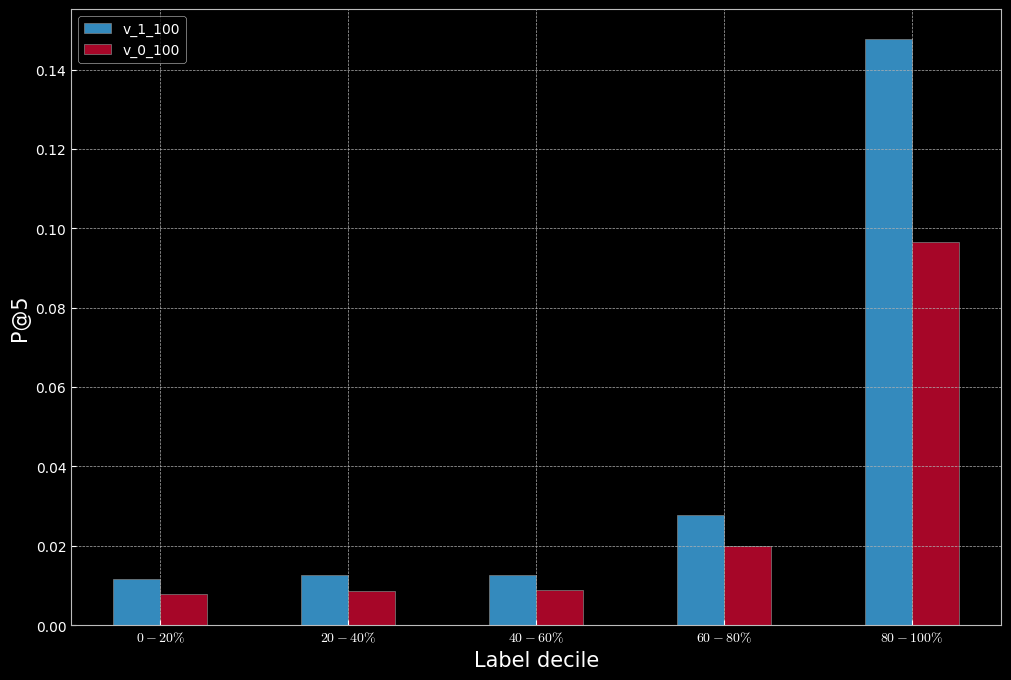

In [354]:
_plot_multiple_bar_plot([v_1_100_lbl_eval, v_0_100_lbl_eval], 
                        ["v_1_100", "v_0_100"], "Label decile", "P@5")

In [355]:
(np.array(v_1_100_lbl_eval) - np.array(v_0_100_lbl_eval))/np.array(v_0_100_lbl_eval)

array([0.49261758, 0.47223966, 0.45198385, 0.38040026, 0.53215051])

In [356]:
v_0_100_lbl_eval

[0.007860664778426408,
 0.008569331340048501,
 0.008756105715833934,
 0.020086315894653095,
 0.09647626697206454]

In [357]:
v_1_100_lbl_eval

[0.011732966445944959,
 0.0126161094820662,
 0.012713724073526077,
 0.027727155687587195,
 0.14781616174814668]